In [12]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

$f(x) = \frac{1}{2}\|x\|_2^2$, JAX computes $\nabla{f} : \mathbb{R}^n \to \mathbb{R}^n$ where $\nabla{f}(x) = x$.

In [4]:
def f(x):
    return jnp.sum(x**2) / 2 

grad_f = jax.grad(f)
x = jnp.array([1.0, 2.0, 3.0])
print('x:', x)
print('f(x):', f(x))
print('grad_f(x):', grad_f(x))

x: [1. 2. 3.]
f(x): 13.0
grad_f(x): [7. 5. 5.]


Vector Jacobian Product (VJP) is defined as $J^T v = \nabla{f}(x)^T v$ where $v \in \mathbb{R}^n$.


E.g., if $f(x) = \frac{1}{2}\|x\|_2^2$, then $\nabla{f}(x) = x \cdot 1$.

In [16]:
f = lambda x: jnp.sum(x**2) / 2
x = jnp.array([0., 2.0, 3.0])
f_x, dfxT = jax.vjp(f, x)
dfxT_1 = dfxT(1.0)
print('x:', x)
print('f(x):', f_x)
print('grad_f(x):', dfxT_1)

x: [0. 2. 3.]
f(x): 6.5
grad_f(x): (Array([0., 2., 3.], dtype=float32),)


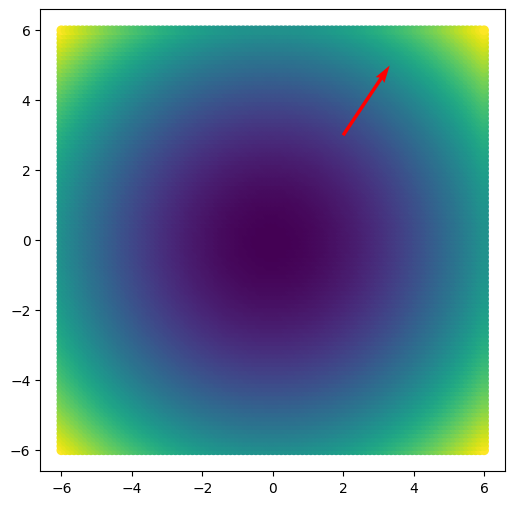

In [20]:
xs1, xs2 = jnp.meshgrid(
    jnp.linspace(-6, 6, 101), 
    jnp.linspace(-6, 6, 101))
xs1 = xs1.reshape(101**2, 1)
xs2 = xs2.reshape(101**2, 1)
xs = jnp.concatenate((xs1, xs2), axis=-1)
fs = jax.vmap(f)(xs)
plt.figure(figsize=[6, 6])
plt.scatter(xs1, xs2, c=fs)
plt.quiver(x[1], x[2], dfxT_1[0][1], dfxT_1[0][2],
    scale=20, color='r')
plt.show()

VJP and JVP for Maxtrix input: $$
\begin{aligned}
f : \mathbb{R}^{n \times n} &\to \mathbb{R} \\
X &\mapsto a^\top X b
\end{aligned}
$$

In [21]:
def f(X):
    a, b = jnp.array([0., 1., 2.]), jnp.array([0., 1., 2.])
    return a @ (X @ b)

X = jnp.ones((3, 3))
f_x = f(X)
w, V = jnp.array(1.), jnp.eye(3)
f_x, dfT = jax.vjp(f, X)
f_x, df_v = jax.jvp(f, (X,), (V,))

print('X:\n', X, '\n', 'f(X): ', f_x, '\n', sep='')
print('dfT(1):\n', dfT(w), '\n', 'df(I): ', df_v, sep='')

X:
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
f(X): 9.0

dfT(1):
(Array([[0., 0., 0.],
       [0., 1., 2.],
       [0., 2., 4.]], dtype=float32),)
df(I): 5.0


To calculate f(x) for many different values of x without looping -> vectorizing a function with JAX

In [22]:
f = lambda x: jnp.array([jnp.sum(x**2)/2, jnp.linalg.norm(x, jnp.inf)])
f = jax.vmap(f)

batch_size, n = 100, 3
x = jnp.ones((batch_size, n))  # dummy values with desired shape

print(x.shape)
print(f(x).shape)

(100, 3)
(100, 2)


## Example: Linearizing Dynamics at Many Points
For $\dot{x} = f(x,u)$ with $x \in \mathbb{R}^n$ and $u \in \mathbb{R}^m$, recall the first-order Taylor approximation

$$
f(x,u) \approx \underbrace{f(\bar{x}_k,\bar{u}_k)}_{= c_k}
    + \underbrace{\partial_x{f}(\bar{x}_k,\bar{u}_k)}_{= A_k}(x - \bar{x})
    + \underbrace{\partial_u{f}(\bar{x}_k,\bar{u}_k)}_{= B_k}(u - \bar{u}).
$$

We want $A_k\Delta{x}_t$, $B_k\Delta{u}_t$, and $c_k$ for $\{(\bar{x}_k,\bar{u}_k)\}_{k=1}^K$ and $\{(\Delta{x}_t,\Delta{u}_t)\}_{t=1}^T$.

This scenario may correspond to evaluating Taylor approximations for $T$ perturbations $(\Delta{x}_t,\Delta{u}_t)$ that we want to test at the $K$ points $(\bar{x}_k,\bar{u}_k)$.

In [23]:
# Inverted pendulum (with unit mass and unit length)
f = lambda x, u: jnp.array([x[1], 9.81*jnp.sin(x[0]) + u[0]])

def taylor(x̄, ū, Δx, Δu):
    f_x̄ū, AΔx = jax.jvp(lambda x: f(x, ū), (x̄,), (Δx,))
    _, BΔu = jax.jvp(lambda u: f(x̄, u), (ū,), (Δu,))
    return f_x̄ū, AΔx, BΔu

print(type(taylor))

n, m = 2, 1
K, T = 5, 10
x̄, ū = jnp.ones((K, n)), jnp.ones((K, m))
Δx, Δu = jnp.ones((T, n)), jnp.ones((T, m))

taylor = jax.vmap(taylor, in_axes=(None, None, 0, 0))
print(type(taylor))

taylor = jax.vmap(taylor, in_axes=(0, 0, None, None))
print(type(taylor))

c, Ax, Bu = taylor(x̄, ū, Δx, Δu)
print(c.shape)
print(Ax.shape)
print(Bu.shape)

<class 'function'>
<class 'function'>
<class 'function'>
(5, 10, 2)
(5, 10, 2)
(5, 10, 2)


In [24]:
# Inverted pendulum (with unit mass and unit length)
f = lambda x, u: jnp.array([x[1], 9.81*jnp.sin(x[0]) + u[0]])
def taylor(x̄, ū, Δx, Δu):
    f_x̄ū, AΔx = jax.jvp(lambda x: f(x, ū), (x̄,), (Δx,))
    f_x̄ū, BΔu = jax.jvp(lambda u: f(x̄, u), (ū,), (Δu,))
    return f_x̄ū, AΔx, BΔu

n, m = 2, 1
K, T = 5, 10
x̄ = jnp.ones((K, T, n)) # note the different sizes
ū = jnp.ones((K, T, m))
Δx, Δu = jnp.ones((K, T, n)), jnp.ones((K, T, m))

# two successive calls to vmap:
# we linearize for the K trajectories that each have T timesteps
taylor = jax.vmap(taylor)
taylor = jax.vmap(taylor)

c, Ax, Bu = taylor(x̄, ū, Δx, Δu)
print(c.shape)
print(Ax.shape)
print(Bu.shape)

(5, 10, 2)
(5, 10, 2)
(5, 10, 2)
